In [1]:
import os

#os.environ['TF_DISABLE_MKL'] = '1'

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
from random import shuffle
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import SGD
import matplotlib.image as mpimg
import time
from tensorflow.keras.utils import plot_model
import random
from datetime import datetime
from datetime import date
from random import randint
from tensorflow.keras.callbacks import TensorBoard
import pandas as pd
from PIL import Image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Input, BatchNormalization, MaxPool2D
import csv

import progressbar
from plotly import tools
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
from sklearn.model_selection import train_test_split
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')




from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path = "D:/cours/quatrième année/Deep learning/Projet kaggle plant patho/data/"
path_image = path+"images/"

In [3]:
def load_data_from_csv(path, test_size=0.3):
    
    df_samples = pd.read_csv(path+"new_train.csv")
    df_train, df_valid = train_test_split(df_samples, test_size=test_size, random_state=4)
    
    return df_samples, df_train, df_valid

df_samples, df_train, df_valid = load_data_from_csv(path)
df_samples.sample(4)

image_id  healthy  multiple_diseases  rust  scab
2033   datagen_0_0_601.jpg        1                  0     0     0
133          Train_133.jpg        0                  0     1     0
2689  datagen_1_0_5574.jpg        0                  1     0     0
1853  datagen_0_0_1758.jpg        1                  0     0     0

In [4]:
def get_time():
    
    now = datetime.now()
    current_time = now.strftime("%H-%M-%S")
    today = str(date.today()).split('-')
    today = today[2]+"_"+today[1]+"_"+today[0]
    runTime = ("%s_%s" %(today,current_time))
    return runTime


In [5]:
def log_name():
    
    NAME = "Model_CNN_"+str(ID)+"_"+getTime()
    return NAME

In [6]:
def read_image(sample_path:str, resize_to=False) -> np.ndarray:
 
        
    im = Image.open(sample_path)
    if resize_to:
        im = im.resize(resize_to)
    im = np.array(im) / 255.0
    im = im.astype("float32")

    return im

In [7]:
def humanize_time(secs):
    mins, secs = divmod(secs, 60)
    hours, mins = divmod(mins, 60)
    return ('RUN TIME : %02d:%02d:%02d' % (hours, mins, secs))

In [8]:
def reshape_input(img: np.ndarray) -> np.ndarray:
    
    img.reshape(img.shape[0] * img.shape[1] * img.shape[2]) #
    return img

In [9]:
def load_data(df, resize_to=(512,512), train=True):
    array_images = []
    pbar = progressbar.ProgressBar()
    if train:
        array_labels = []
        for idx, img in pbar(enumerate(df.image_id)):

            array_images.append(reshape_input(read_image(path_image+img, resize_to=resize_to)))
            array_labels.append(list(df.iloc[idx][1:]))

        return np.array(array_images), np.array(array_labels)
    
    for idx, img in pbar(enumerate(df.image_id)):

        array_images.append(reshape_input(read_image(path_image+img, resize_to=resize_to))) 
    
    return np.array(array_images)

x_train, y_train = load_data(df_train, resize_to=(64,64))
x_valid, y_valid = load_data(df_valid, resize_to=(64,64))

| |  #                                             | 2969 Elapsed Time: 0:01:35
| |           #                                    | 1272 Elapsed Time: 0:00:39


In [10]:
def humaines_labels(position):
    labels = list(df_samples.columns[1:])
    return labels[position]

In [11]:
print(y_train.shape)
print(x_train.shape)

(2970, 4)
(2970, 64, 64, 3)


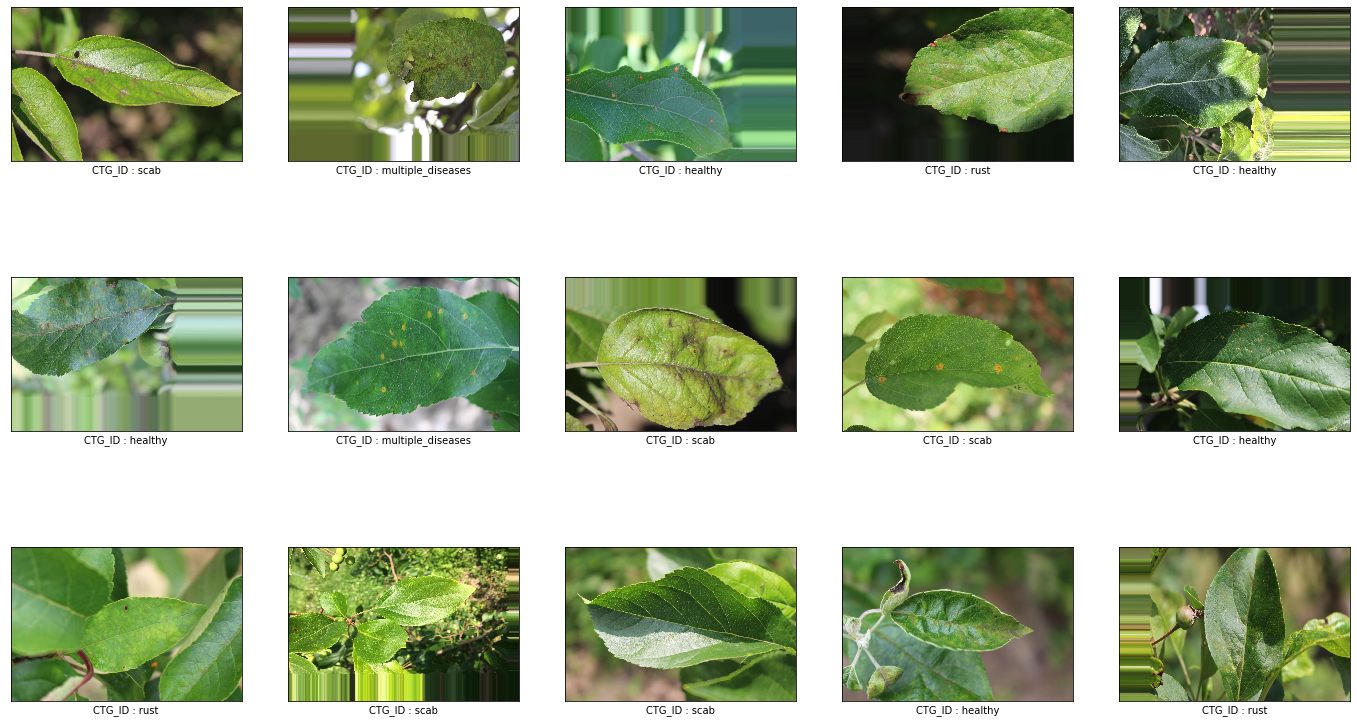

In [12]:
def plot_samples(df, size=(22,22), nb_samples=20, cmap=False):
    
    plt.figure(figsize=size)
    humnaize_labels = df.columns[1:]
    for i in range(nb_samples):
        random_sample = df.iloc[np.random.random_integers(i,len(df) - 1)]
        
        if cmap:
            random_sample_img = Image.open(path_image+random_sample['image_id']).convert("L")
        else:
            random_sample_img = mpimg.imread(path_image+random_sample['image_id'])
            
        arr = np.asarray(random_sample_img)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        if cmap:
            plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(random_sample_img, cmap=plt.cm.binary)
          
        plt.xlabel("CTG_ID : %s" % (humaines_labels(np.argmax(list(df.iloc[i][1:])))))
    plt.show()
    
plot_samples(df_samples, size=(24,24), nb_samples=15)

In [13]:
'''
tf.keras.backend.clear_session()
# RESNET-34 'classique'
input_layer = Input(shape=(512, 512, 3))

#init block

last_output = Conv2D(64, kernel_size = (7,7), strides = (1,1), padding = 'same',
                      name='conv_7x7__64__0')(input_layer)

last_output = Activation(activation='relu', name="Activation_0")(last_output)
last_output = MaxPooling2D((3, 3), name='max_pool_0')(last_output)
last_output = Dropout(0.25)(last_output)

count = 1
for i in range(1, 4):
    
    block_input = last_output
    last_output = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1    

    last_output = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1
    
   
    
    block_input = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = 'same',
                        name='conv_identity'+str(i) )(block_input)
    
    
    
    last_output = Add(name=f"Add_output_{i}")([last_output, block_input])
    last_output = Dropout(0.25)(last_output)
    
last_output = MaxPooling2D((3, 3), name='max_pool_1')(last_output)


for i in range(4, 8):
    
    block_input = last_output
    last_output = Conv2D(128, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1    

    last_output = Conv2D(128, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1
    
   
    
    block_input = Conv2D(128, kernel_size = (3,3), strides = (1,1), padding = 'same',
                        name='conv_identity'+str(i) )(block_input)
    
    
    
    last_output = Add(name=f"Add_output_{i}")([last_output, block_input])
    last_output = Dropout(0.25)(last_output)
       
last_output = MaxPooling2D((3, 3), name='max_pool_2')(last_output)
    
    
for i in range(8, 14):
    
    block_input = last_output
    last_output = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1    

    last_output = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1
    
   
    
    block_input = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same',
                        name='conv_identity'+str(i) )(block_input)
    
    
    
    last_output = Add(name=f"Add_output_{i}")([last_output, block_input])
    last_output = Dropout(0.25)(last_output)

last_output = MaxPooling2D((3, 3), name='max_pool_3')(last_output)


for i in range(14, 17):
    
    block_input = last_output
    last_output = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1    

    last_output = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          name=f"Conv_3x3__64__{count}")(last_output)
    last_output = Activation(activation='relu', name=f"Activation_{count}")(last_output)
    count += 1
    
   
    
    block_input = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same',
                        name='conv_identity'+str(i) )(block_input)
    
    
    
    last_output = Add(name=f"Add_output_{i}")([last_output, block_input])
    last_output = Dropout(0.25)(last_output) 
   
    
last_output = AveragePooling2D((3, 3), name='avg_pool_4')(last_output)

#output

flatten_layer_output = Flatten(name="flatten")(last_output)  
#last_output = Dense(128, activation='relu', name='mlp_end')(flatten_layer_output)
#last_output = Dropout(0.25)(last_output)         


output_tensor = Dense(4, activation='softmax', name=f"Dense_output")(flatten_layer_output)
print(last_output.shape) 
model = Model(input_layer, output_tensor)

optimizer_1 = Adam(lr=0.001)
optimizer_2 = SGD(lr=0.01)
#model.compile(optimizer=optimizer_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(loss="categorical_crossentropy", optimizer=optimizer_1, metrics=["accuracy"])'''

'\ntf.keras.backend.clear_session()\n# RESNET-34 \'classique\'\ninput_layer = Input(shape=(512, 512, 3))\n\n#init block\n\nlast_output = Conv2D(64, kernel_size = (7,7), strides = (1,1), padding = \'same\',\n                      name=\'conv_7x7__64__0\')(input_layer)\n\nlast_output = Activation(activation=\'relu\', name="Activation_0")(last_output)\nlast_output = MaxPooling2D((3, 3), name=\'max_pool_0\')(last_output)\nlast_output = Dropout(0.25)(last_output)\n\ncount = 1\nfor i in range(1, 4):\n    \n    block_input = last_output\n    last_output = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = \'same\',\n                          name=f"Conv_3x3__64__{count}")(last_output)\n    last_output = Activation(activation=\'relu\', name=f"Activation_{count}")(last_output)\n    count += 1    \n\n    last_output = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding = \'same\',\n                          name=f"Conv_3x3__64__{count}")(last_output)\n    last_output = Activation(ac

In [18]:
#HAMZA CODE
#init
tf.keras.backend.clear_session()
input_layer = Input(shape=(64, 64, 3))

#last_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = 'same',
#                      kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2= 0.0001),name='conv_0')(input_layer)

#first block
block_input = input_layer
last_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = 'same',name='conv_0')(input_layer)
last_output = Activation(activation='relu', name="Activation_0")(last_output)

last_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = 'same',name='conv_0')(input_layer)
last_output = Activation(activation='relu', name="Activation_0")(last_output)


block_input = Conv2D(60, kernel_size = (3,3), strides = (1,1), padding = 'same', name='conv_identity_0' )(block_input)
last_output = Add(name=f"Add_output_0")([last_output, block_input])

last_output = MaxPooling2D((4, 4), name='max_pool_0')(last_output)
last_output = Dropout(0.25)(last_output)


#second block
block_input = input_layer
last_output = Conv2D(120, kernel_size = (5,5), strides = (1,1), padding = 'same',name='conv_1')(input_layer)
last_output = Activation(activation='relu', name="Activation_1")(last_output)

block_input = Conv2D(120, kernel_size = (3,3), strides = (1,1), padding = 'same', name='conv_identity_1' )(block_input)
last_output = Add(name=f"Add_output_1")([last_output, block_input])

last_output = MaxPooling2D((3, 3), name='max_pool_1')(last_output)
last_output = Dropout(0.25)(last_output)


#third block
block_input = input_layer
last_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = 'same',name='conv_2')(input_layer)
last_output = Activation(activation='relu', name="Activation_2")(last_output)

block_input = Conv2D(60, kernel_size = (3,3), strides = (1,1), padding = 'same', name='conv_identity_2' )(block_input)
last_output = Add(name=f"Add_output_2")([last_output, block_input])

last_output = MaxPooling2D((2, 2), name='max_pool_2')(last_output)
last_output = Dropout(0.25)(last_output)


#flatten
flatten_layer_output = Flatten(name="flatten")(last_output)  
flatten_layer_output = Dropout(0.35)(flatten_layer_output)


#output
#output_tensor = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2= 0.0001), name=f"Dense")(flatten_layer_output)
output_tensor = Dense(4, activation='softmax', name=f"Dense_output")(output_tensor)

model = Model(input_layer, output_tensor)

optimizer_1 = Adam(lr=0.001)
optimizer_2 = SGD(lr=0.01)

model.compile(loss="categorical_crossentropy", optimizer=optimizer_1, metrics=["accuracy"])

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(None, 64, 64, 3), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

In [19]:
'''#try 2
tf.keras.backend.clear_session()
#kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2= 0.0001),

#init
input_layer = Input(shape=(128, 128, 3))

#first block
block_input = input_layer

last_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = 'same', 
                      name='conv_0')(input_layer)
last_output = Activation(activation='relu', name="Activation_0")(last_output)
#last_output = BatchNormalization()(last_output)
#last_output = Dropout(0.4)(last_output)

last_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = 'same',
                       name='conv_1')(input_layer)
last_output = Activation(activation='relu', name="Activation_1")(last_output)
#last_output = BatchNormalization()(last_output)
#last_output = Dropout(0.4)(last_output)

                    
block_input = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = 'same', name='conv_identity_0' )(block_input)
last_output = Add(name=f"Add_output_0")([last_output, block_input])

last_output = MaxPooling2D((4, 4), name='max_pool_0')(last_output)
#last_output = BatchNormalization()(last_output)
last_output = Dropout(0.25)(last_output)



#second block
block_input = input_layer

#last_output = Conv2D(120, kernel_size = (3,3), strides = (1,1), padding = 'same', 
#                     kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2= 0.0001), name='conv_2')(input_layer)
#last_output = Activation(activation='relu', name="Activation_2")(last_output)
#last_output = BatchNormalization()(last_output)
#last_output = Dropout(0.4)(last_output)

last_output = Conv2D(120, kernel_size = (2,2), strides = (1,1), padding = 'same',
                       name='conv_3')(input_layer)
last_output = Activation(activation='relu', name="Activation_2")(last_output)
#last_output = BatchNormalization()(last_output)
#last_output = Dropout(0.4)(last_output)

                    
block_input = Conv2D(120, kernel_size = (2,2), strides = (1,1), padding = 'same', name='conv_identity_1' )(block_input)
last_output = Add(name=f"Add_output_1")([last_output, block_input])

last_output = MaxPooling2D((3, 3), name='max_pool_1')(last_output)
#last_output = BatchNormalization()(last_output)
last_output = Dropout(0.4)(last_output)


                     
#third block
block_input = input_layer

last_output = Conv2D(120, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      name='conv_4')(input_layer)
last_output = Activation(activation='relu', name="Activation_4")(last_output)
#last_output = BatchNormalization()(last_output)
#last_output = Dropout(0.4)(last_output)

#last_output = Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same',
#                      kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2= 0.0001), name='conv_5')(input_layer)
#last_output = Activation(activation='relu', name="Activation_5")(last_output)
#last_output = BatchNormalization()(last_output)
#last_output = Dropout(0.4)(last_output)

                    
block_input = Conv2D(120, kernel_size = (3,3), strides = (1,1), padding = 'same', name='conv_identity_2' )(block_input)
last_output = Add(name=f"Add_output_2")([last_output, block_input])

last_output = MaxPooling2D((2, 2), name='max_pool_2')(last_output)
last_output = BatchNormalization()(last_output)
last_output = Dropout(0.25)(last_output)


#flatten
flatten_layer_output = Flatten(name="flatten")(last_output)  
flatten_layer_output = Dropout(0.35)(flatten_layer_output)


#output
output_tensor = Dense(128, activation='relu', name=f"Dense_output")(flatten_layer_output)
output_tensor = Dense(4, activation='softmax', name=f"Dense_output")(output_tensor)

model = Model(input_layer, output_tensor)

optimizer_1 = Adam(lr=0.001)
optimizer_2 = SGD(lr=0.01)

model.compile(loss="categorical_crossentropy", optimizer=optimizer_1, metrics=["accuracy"])'''

'#try 2\ntf.keras.backend.clear_session()\n#kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2= 0.0001),\n\n#init\ninput_layer = Input(shape=(128, 128, 3))\n\n#first block\nblock_input = input_layer\n\nlast_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = \'same\', \n                      name=\'conv_0\')(input_layer)\nlast_output = Activation(activation=\'relu\', name="Activation_0")(last_output)\n#last_output = BatchNormalization()(last_output)\n#last_output = Dropout(0.4)(last_output)\n\nlast_output = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = \'same\',\n                       name=\'conv_1\')(input_layer)\nlast_output = Activation(activation=\'relu\', name="Activation_1")(last_output)\n#last_output = BatchNormalization()(last_output)\n#last_output = Dropout(0.4)(last_output)\n\n                    \nblock_input = Conv2D(60, kernel_size = (5,5), strides = (1,1), padding = \'same\', name=\'conv_identity_0\' )(block_input)\nlast_output = Add(name=f"A

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 64, 64, 60)   4560        input_1[0][0]                    
__________________________________________________________________________________________________
Activation_2 (Activation)       (None, 64, 64, 60)   0           conv_2[0][0]                     
__________________________________________________________________________________________________
conv_identity_2 (Conv2D)        (None, 64, 64, 60)   1680        input_1[0][0]                    
______________________________________________________________________________________________

In [21]:
data_aug_lvl = '3'
batch_size = 50
epochs = 200


if data_aug_lvl == '1':
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    print("Simple data aug")
elif data_aug_lvl == '2':
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.3)
    print("Moyenne data aug")
elif data_aug_lvl == '3':
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.3, rotation_range=45)
    print("Grosse data aug")

    
if (data_aug_lvl == '1' or data_aug_lvl == '2' or data_aug_lvl == '3'):    
    # On crée un "iterator"
    it_train = datagen.flow(x_train, y_train, batch_size=batch_size)
    #On va devoir ajouter l'attribut steps_per_epoch au fit, il donne le nombre d'expemples de data aug présents dans chaque epoch
    steps = int(x_train.shape[0] / batch_size)

    # Entrainer le modele
    history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=epochs,
                validation_data=(x_valid, y_valid), verbose=1)

else :
    print("no data aug")
    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                        validation_data=(x_valid, y_valid))

Grosse data aug
Epoch 1/200
59/59 [==============================] - 8s 136ms/step - loss: 2.0899 - accuracy: 0.4349 - val_loss: 2.2016 - val_accuracy: 0.4030
Epoch 2/200
59/59 [==============================] - 7s 125ms/step - loss: 2.1657 - accuracy: 0.4469 - val_loss: 2.2455 - val_accuracy: 0.4014
Epoch 3/200
59/59 [==============================] - 8s 132ms/step - loss: 2.0375 - accuracy: 0.4380 - val_loss: 1.9651 - val_accuracy: 0.4391
Epoch 4/200
59/59 [==============================] - 8s 137ms/step - loss: 1.9155 - accuracy: 0.4483 - val_loss: 1.9826 - val_accuracy: 0.3881
Epoch 5/200
59/59 [==============================] - 8s 131ms/step - loss: 1.9404 - accuracy: 0.4438 - val_loss: 2.2936 - val_accuracy: 0.3833
Epoch 6/200
59/59 [==============================] - 8s 130ms/step - loss: 2.0942 - accuracy: 0.4512 - val_loss: 2.0302 - val_accuracy: 0.4423
Epoch 7/200
59/59 [==============================] - 8s 128ms/step - loss: 1.9582 - accuracy: 0.4567 - val_loss: 1.9437 - val_

Epoch 58/200
59/59 [==============================] - 8s 130ms/step - loss: 1.8703 - accuracy: 0.5147 - val_loss: 2.0904 - val_accuracy: 0.4242
Epoch 59/200
59/59 [==============================] - 7s 124ms/step - loss: 1.8524 - accuracy: 0.5024 - val_loss: 2.0620 - val_accuracy: 0.4564
Epoch 60/200
59/59 [==============================] - 8s 129ms/step - loss: 1.8860 - accuracy: 0.5045 - val_loss: 2.0493 - val_accuracy: 0.4564
Epoch 61/200
59/59 [==============================] - 7s 127ms/step - loss: 1.8666 - accuracy: 0.5147 - val_loss: 2.1089 - val_accuracy: 0.4006
Epoch 62/200
59/59 [==============================] - 8s 133ms/step - loss: 1.8722 - accuracy: 0.5139 - val_loss: 2.3686 - val_accuracy: 0.3975
Epoch 63/200
59/59 [==============================] - 8s 130ms/step - loss: 1.8705 - accuracy: 0.5131 - val_loss: 2.0268 - val_accuracy: 0.4493
Epoch 64/200
59/59 [==============================] - 8s 129ms/step - loss: 1.8705 - accuracy: 0.5264 - val_loss: 2.5025 - val_accuracy:

Epoch 115/200
59/59 [==============================] - 8s 128ms/step - loss: 1.8118 - accuracy: 0.5747 - val_loss: 1.9277 - val_accuracy: 0.5255
Epoch 116/200
59/59 [==============================] - 8s 129ms/step - loss: 1.8078 - accuracy: 0.5822 - val_loss: 2.6445 - val_accuracy: 0.3912
Epoch 117/200
59/59 [==============================] - 8s 130ms/step - loss: 1.8300 - accuracy: 0.5760 - val_loss: 1.8878 - val_accuracy: 0.5491
Epoch 118/200
59/59 [==============================] - 8s 129ms/step - loss: 1.8259 - accuracy: 0.5757 - val_loss: 1.7886 - val_accuracy: 0.5766
Epoch 119/200
59/59 [==============================] - 8s 129ms/step - loss: 1.8450 - accuracy: 0.5627 - val_loss: 1.8373 - val_accuracy: 0.5491
Epoch 120/200
59/59 [==============================] - 8s 129ms/step - loss: 1.8143 - accuracy: 0.5801 - val_loss: 1.8268 - val_accuracy: 0.5766
Epoch 121/200
59/59 [==============================] - 8s 129ms/step - loss: 1.8152 - accuracy: 0.5729 - val_loss: 2.0449 - val_ac

In [22]:
def evaluateModel(model, testImages, testLabels):
    
    return model.evaluate(testImages, testLabels, batch_size=50, verbose=2)

evaluateModel(model, x_valid, y_valid)

1273/1 - 1s - loss: 1.8072 - accuracy: 0.5318


[2.0670634254356677, 0.53181463]

In [23]:
def predictionPercent(model, testImages, testLabels):
    
    prediction = model.predict(testImages)
    predicted = []
    for i in range(len(prediction)):
        if np.argmax(testLabels[i]) == np.argmax(prediction[i]):
            predicted.append(1)
        else:
            predicted.append(0)
    print("Predicted percent {} %".format((sum(predicted)/(len(predicted)) * 100)))
    result = (sum(predicted)/len(predicted)) * 100
    
    return prediction, result

prd, result = predictionPercent(model, x_valid, y_valid)

Predicted percent 53.18146111547526 %


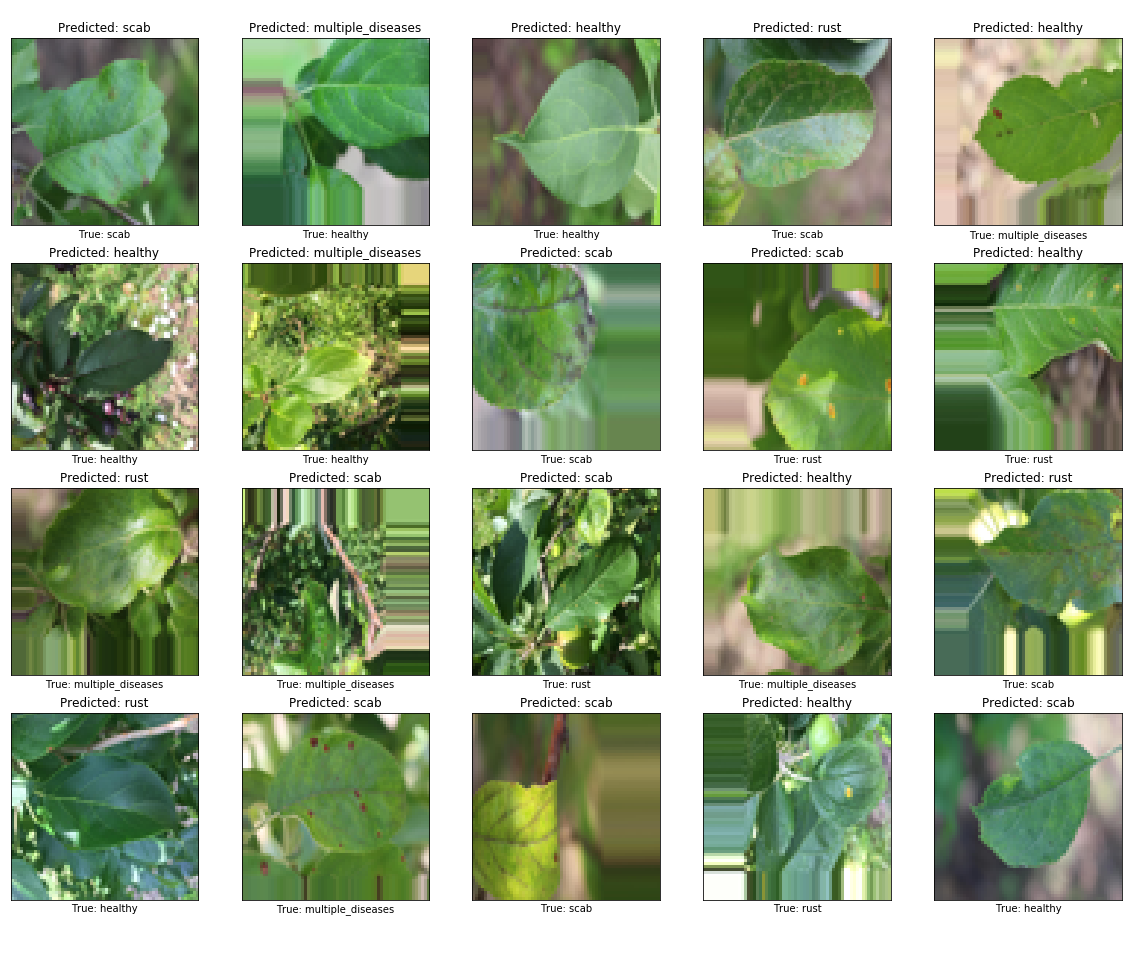

In [24]:
def plotPredictedResult(prediction, df,  testImages, testLabels):
    
    humnaize_labels = df.columns[1:]
    plt.figure(figsize=(20, 20))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(testImages[i])
        plt.xlabel("True: "+humnaize_labels[(np.argmax(testLabels[i]))]+"\n\n\n")
        plt.title("\nPredicted: "+humnaize_labels[np.argmax(list(df.iloc[i][1:]))])
        
    plt.show()

plotPredictedResult(prd, df_samples, x_valid, y_valid)

In [25]:
def trace(x,y,imagesLabels,color):
        trace = go.Scatter(
            x = x,y = y,
            name=imagesLabels,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plotAccLoss(model):
    
    hist = model.history
    acc = hist['accuracy']
    valAcc = hist['val_accuracy']
    loss = hist['loss']
    valLoss = hist['val_loss']

    epochs = list(range(1,len(acc)+1))

    traceA = trace(epochs,acc,"Training accuracy", "Green")
    traceVa = trace(epochs,valAcc,"Validation accuracy", "Red")
    traceL = trace(epochs,loss,"Training loss", "Blue")
    traceVl = trace(epochs,valLoss,"Validation loss", "Magenta")

    fig = plotly.subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(traceA,1,1)
    fig.append_trace(traceVa,1,1)
    fig.append_trace(traceL,1,2)
    fig.append_trace(traceVl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])


    iplot(fig, filename='accuracy-loss')
          
plotAccLoss(history)

In [26]:
ID = np.random.random_integers(1000, 999999)
def save_model(model, ID, result):
    
    now = datetime.now()
    current_time = now.strftime("%H-%M-%S")
    today = str(date.today()).split('-')
    today = today[2]+"_"+today[1]+"_"+today[0]
    runTime = ("%s_%s" %(today,current_time))
    model.save('D:\PlantPato\Models\cnn\model_run_'+runTime+"_"+str(ID)+"_["+str(round(result, 2))+"]")

save_model(model, ID, result)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\PlantPato\Models\cnn\model_run_22_05_2020_20-59-58_622053_[53.18]\assets


In [ ]:
df_samples_test = pd.read_csv(path+"test.csv")
copy_df_samples = pd.read_csv(path+"test.csv")
df_samples_test['image_id'] = pd.Series([img+'.jpg' for img in df_samples_test.image_id if '.jpg' not in img])

In [ ]:
# df_samples_test.head(4)
copy_df_samples.head(4)

In [ ]:
x_test = load_data(df_samples_test, resize_to=(64,64), train=False)

In [ ]:
predictions = model.predict(x_test, verbose=2)

In [ ]:
dict_submit = {'image_id':list(copy_df_samples.image_id), 'healthy':list(predictions[:,0]), 'multiple_diseases':list(predictions[:,1]), 'rust':list(predictions[:,2]), 'scab':list(predictions[:,3])}
sample_submission_df = pd.DataFrame(dict_submit)

In [ ]:
sample_submission_df.head(4)

In [ ]:
sample_submission_df.to_csv('../../output/submission/cnn/sample_submission.csv', sep=',', index=False)